## Simple GAN using MNIST.

reference: https://github.com/udacity/deep-learning/blob/master/gan_mnist/Intro_to_GANs_Solution.ipynb

unlike Udacity code, low level tensoflow is used to build the GAN.
Display codes are copied from the reference. 

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../MNIST_data', validation_size=0)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


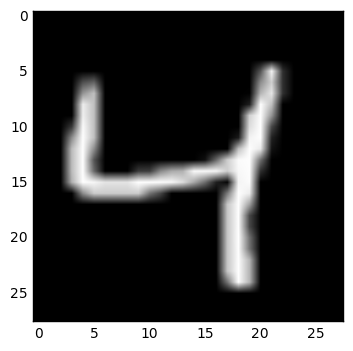

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
plt.show()

In [4]:
def weight_variable(shape, name):
    return tf.get_variable(dtype=tf.float32, shape=shape, name=name)

def bias_variable(shape, name):
    return tf.get_variable(shape=shape, dtype=tf.float32, 
                           name=name, initializer=tf.zeros_initializer)

def leaky_relu(x, alpha=0.01):
    return tf.maximum(x, x * alpha)

In [5]:
# define hyperparameters
x_size = 784
z_size = 100

In [6]:
# create generator 
def generator_model(z, reuse=False):
    with tf.variable_scope("generator", reuse=reuse):
        # hidden layer 
        W1 = weight_variable(shape=[z_size, 128], name="weight_hidden")
        b1 = bias_variable(shape=[128], name="bias_hidden")
        h1 = leaky_relu(tf.matmul(z, W1) + b1, alpha=0.01)
        
        # output
        W2 = weight_variable(shape=[128, x_size], name="weight_out")
        b2 = bias_variable(shape=[x_size], name="bias_out")
        gen_out = tf.tanh(tf.matmul(h1, W2) + b2)
        
        return gen_out

In [7]:
# create discriminator 
def discriminator_logit(x, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse):
        # hidden layer 
        W1 = weight_variable(shape=[x_size, 128], name="weight_hidden")
        b1 = bias_variable(shape=[128], name="bias_hidden")
        h1 = leaky_relu(tf.matmul(x, W1) + b1, alpha=0.01)
        
        # output 
        W2 = weight_variable(shape=[128, 1], name="weight_out")
        b2 = bias_variable(shape=[1], name="bias_out")
        logit = tf.matmul(h1, W2) + b2
        
        return logit

In [8]:
# build network 
tf.reset_default_graph()
# input for discriminator: x
# input for generator: z
x = tf.placeholder(shape=[None, x_size], dtype=tf.float32)
z = tf.placeholder(shape=[None, z_size], dtype=tf.float32)

# Generator model 
gen_model = generator_model(z=z)

# Discriminator 
dis_logit_real = discriminator_logit(x=x)
dis_logit_fake = discriminator_logit(x=gen_model, reuse=True)

In [9]:
def cross_entropy(logits, labels):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, 
                                                                  labels=labels))

In [10]:
# define loss
# discriminator 
smooth = 0.1
dis_labels_real = tf.ones_like(dis_logit_real) * (1-smooth)
dis_labels_fake = tf.zeros_like(dis_logit_fake)
dis_loss_real = cross_entropy(logits=dis_logit_real, labels=dis_labels_real)
dis_loss_fake = cross_entropy(logits=dis_logit_fake, labels=dis_labels_fake)
dis_loss = dis_loss_real + dis_loss_fake

# generator
gen_label_fake = tf.ones_like(dis_logit_fake)
gen_loss = cross_entropy(logits=dis_logit_fake, labels=gen_label_fake)

In [11]:
# define optimizers
t_vars = tf.trainable_variables()
dis_vars = [var for var in t_vars if var.name.startswith("discriminator")]
gen_vars = [var for var in t_vars if var.name.startswith("generator")]

dis_opt = tf.train.AdamOptimizer(0.002).minimize(dis_loss, var_list=dis_vars)
gen_opt = tf.train.AdamOptimizer(0.002).minimize(gen_loss, var_list=gen_vars)

In [13]:
# training 
batch_size = 200
epochs = 100
samples = []
losses = []
# only save generator variables
saver = tf.train.Saver(var_list=gen_vars)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for i in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            # get imgs, reshape and rescale to pass to discriminator
            batch_imgs = batch[0].reshape((batch_size, 784))
            batch_imgs = batch_imgs*2 - 1
            
            # sample random noise for generator 
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # run optimizers 
            sess.run(dis_opt, feed_dict={x: batch_imgs, z: batch_z})
            sess.run(gen_opt, feed_dict={z: batch_z})
            
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(dis_loss, {z: batch_z, x: batch_imgs})
        train_loss_g = gen_loss.eval({z: batch_z})
            
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))
        
        losses.append((train_loss_d, train_loss_g))
        
        # sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                        generator_model(z, reuse=True), 
                        feed_dict={z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

# save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/100... Discriminator Loss: 0.4399... Generator Loss: 2.4367
Epoch 2/100... Discriminator Loss: 0.3656... Generator Loss: 3.7162
Epoch 3/100... Discriminator Loss: 0.4234... Generator Loss: 2.9640
Epoch 4/100... Discriminator Loss: 2.2010... Generator Loss: 3.4440
Epoch 5/100... Discriminator Loss: 0.7351... Generator Loss: 5.8817
Epoch 6/100... Discriminator Loss: 0.9587... Generator Loss: 2.7275
Epoch 7/100... Discriminator Loss: 1.0820... Generator Loss: 3.5195
Epoch 8/100... Discriminator Loss: 1.2756... Generator Loss: 2.2839
Epoch 9/100... Discriminator Loss: 1.0509... Generator Loss: 1.7167
Epoch 10/100... Discriminator Loss: 1.7410... Generator Loss: 1.1506
Epoch 11/100... Discriminator Loss: 1.3464... Generator Loss: 1.6206
Epoch 12/100... Discriminator Loss: 0.9552... Generator Loss: 1.5981
Epoch 13/100... Discriminator Loss: 0.6654... Generator Loss: 2.5648
Epoch 14/100... Discriminator Loss: 2.9814... Generator Loss: 0.7129
Epoch 15/100... Discriminator Loss: 0.5531.

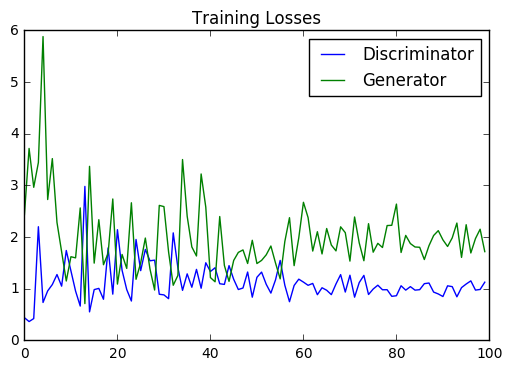

In [16]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

In [42]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

In [43]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

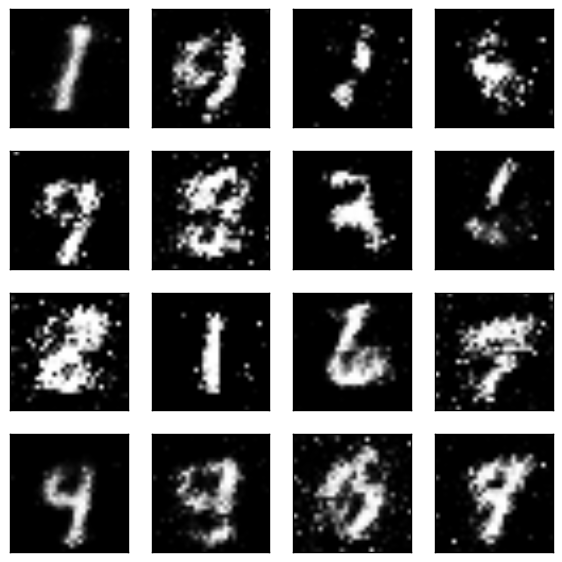

In [44]:
_ = view_samples(-1, samples)
plt.show()

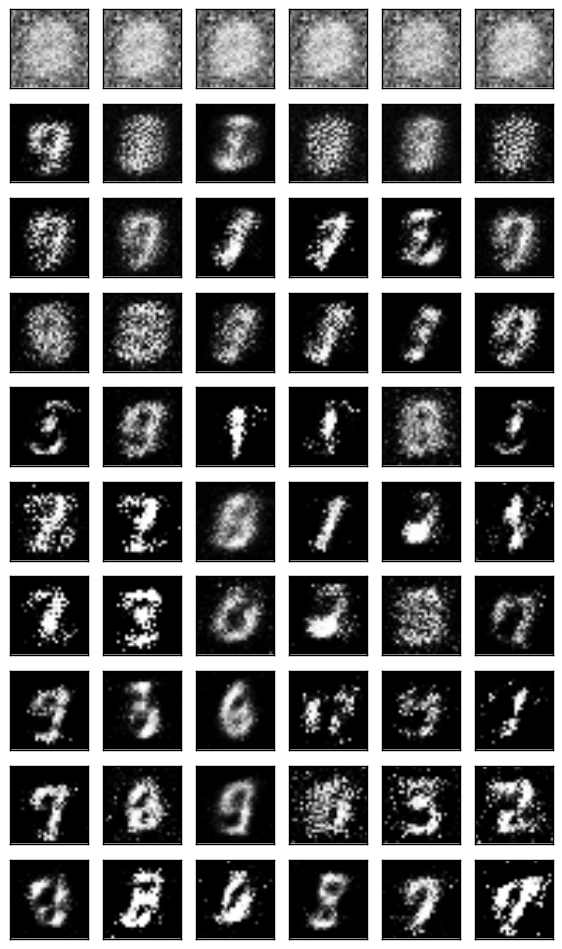

In [28]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

plt.show()

INFO:tensorflow:Restoring parameters from checkpoints/generator.ckpt


/Users/leesuckgeun/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


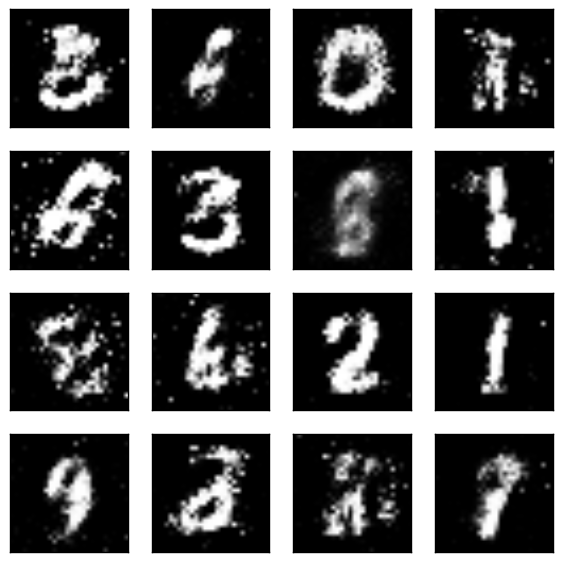

In [30]:
saver = tf.train.Saver(var_list=gen_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    gen_samples = sess.run(
                   generator_model(z, reuse=True),
                   feed_dict={z: sample_z})
_ = view_samples(0, [gen_samples])

plt.show()